# Zone axis alignment

In this notebook, we will calculate the necessary angles to tilt the sample such that a given zone axis is aligned with the optical axis.

In [1]:
# Import the necessary packages
%matplotlib inline
from orix.vector import Vector3d, Miller
import numpy as np

from tiltlib import Axis, Sample

## Load data

We use Orix's austenite crystal map, and a double-tilt sample holder with axes offset by 30 degrees to the scan.

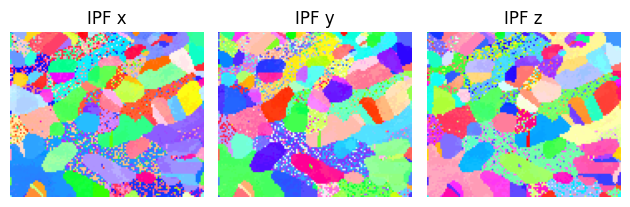

In [2]:
from orix.data import sdss_austenite

# This is the raw data we will use
raw_xmap = sdss_austenite(allow_download=True)

# Define the tilt axes of the sample holder.
# If these are not known, refer to the `tilt_axis_identification.ipynb` example notebook.
x_tilt_axis = Axis(
    Vector3d.xvector().rotate(Vector3d.zvector(), np.deg2rad(30)),
    min=-30, 
    max=30,
    angle=0,
    intrinsic=False,
)
y_tilt_axis = Axis(
    Vector3d.yvector().rotate(Vector3d.zvector(), np.deg2rad(30)),
    min=-30, 
    max=30,
    angle=0,
    intrinsic=True,
) 

# Initialize the sample object
sample = Sample.from_crystal_map(raw_xmap, [x_tilt_axis, y_tilt_axis])

figure = sample.plot()

If you have your own data, replace the axes and crystal map with your own. Remember to assign the correct initial tilt angles to the axes.

## Grain selection

We choose a grain as a target for our optimization with a hyperspy ROI.
Both a box ROI and a circle ROI are supported.

<Signal2D, title: , dimensions: (|11, 6)>

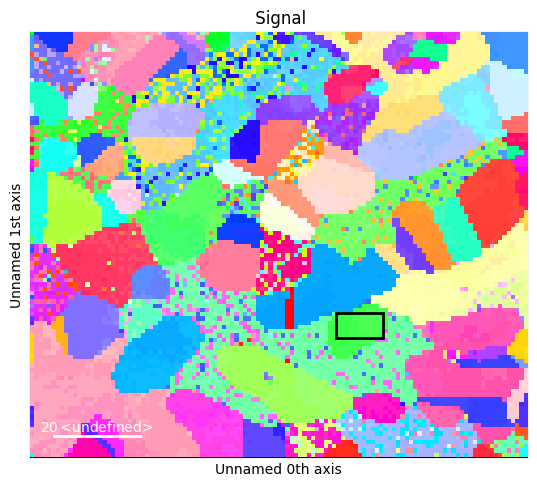

In [3]:
# For example purposes, we have used %matplotlib inline. This makes the plot static.
# For an interactive experience, use e.g. %matplotlib qt5 (needs PyQt5 installed)

# Make a navigation signal, to have an interactive ROI.
nav = sample.to_navigator()
nav.plot()

from hyperspy.roi import RectangularROI

box = RectangularROI(left=72, top=66, right=83, bottom=72)
box.interactive(nav, color="black")

Miller (1,), point group m-3m, uvw
[[  2. -17.  20.]]


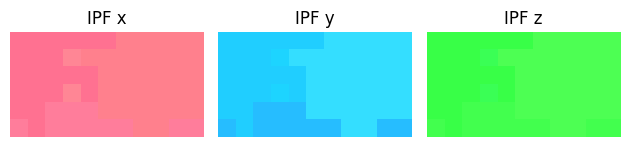

In [4]:
box_crop = sample.crop(box)
box_crop.plot()
print(box_crop.mean_zone_axis())

From the green color, observe that the chosen grain is quite close to [1 0 1]. We will try to align it to that zone axis.

## Find the tilt angles

Now, we choose a miller index, here [1 0 1], and find the angles necessary for aligning the grain to that zone axis.

In [5]:
target = Miller(uvw=[1, 0, 1], phase=sample.phase)

The chosen grain is quite uniform. Therefore, we can choose to optimize using the mean orientation, instead of using the mean angle after using all orientations.
This can provide significant speedup.

In [6]:
box_angles = box_crop.find_tilt_angles(target, use_mean_orientation=True)
print(f"{box_angles = } degrees")

box_angles = array([0.41907898, 5.89399747]) degrees


We can verify the results by calculating the mean zone axis of the crop after rotation, and plotting the sample to see the green color we expect.

Miller (1,), point group m-3m, uvw
[[ 0. -1.  1.]]


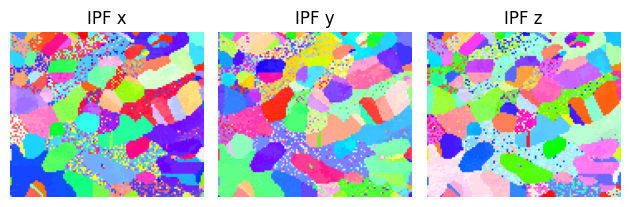

In [7]:
box_crop.rotate_to(*box_angles, degrees=True)
print(box_crop.mean_zone_axis())

sample.rotate_to(*box_angles, degrees=True)
figure = sample.plot()

The grain was indeed close to $\left[1\,0\,1\right]$, since we only needed to tilt about 5 degrees.
Note that we found the symmetrically equivalent $\left[0\,\bar{1}\,1\right]$ rather than $\left[1\,0\,1\right]$.

## Twin alignment

Next, we will try to align two twin grains to the same zone simultaneously.

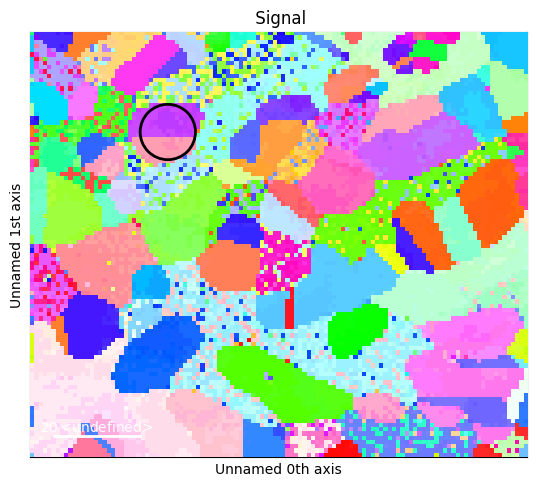

In [8]:
nav = sample.to_navigator()
nav.plot()

from hyperspy.roi import CircleROI

circle = CircleROI(cx=32, cy=23, r=7, r_inner=0)

# Ignore an error which does not affect us
try:
    circle.interactive(nav, color="black")
except np.exceptions.DTypePromotionError:
    pass


These should be $\Sigma3$ twins, and should share a $\left[1\,0\,1\right]$ zone. We use that as target.

In [9]:
circle_crop = sample.crop(circle)
target = Miller(uvw=[1, 0, 1], phase=sample.phase)

To align on multiple grains simultaneously, we no longer want to use the mean orientation.
Since we have two populations of orientations, the mean is not representative of either.
Therefore, we set `use_mean_orientation` to `False`, which is the default value.

In [10]:
circle_angles = circle_crop.find_tilt_angles(target, use_mean_orientation=False)
print(f"{circle_angles = } degrees")

circle_angles = array([-12.86982858, -17.7328452 ]) degrees


Once again, we can verify by plotting the IPF colormap after tilting, and observe that both grains are indeed aligned with $\left[1\,0\,1\right]$

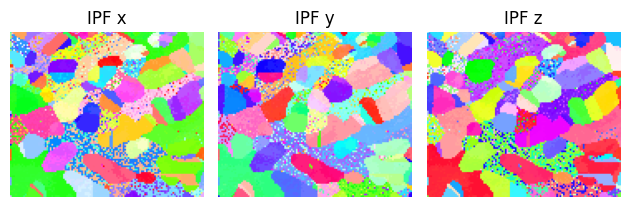

In [11]:
sample.rotate_to(*circle_angles, degrees=True)
fig = sample.plot()

Additionally, we can show how the mean is not representative (before alignment, at least), by adding it to the z-IPF in red:

Text(0.5, 0.98, 'After tilting')

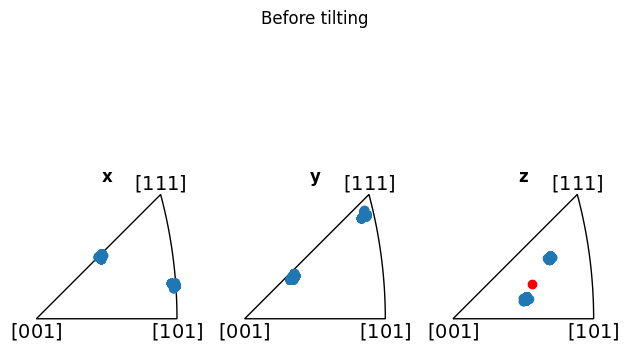

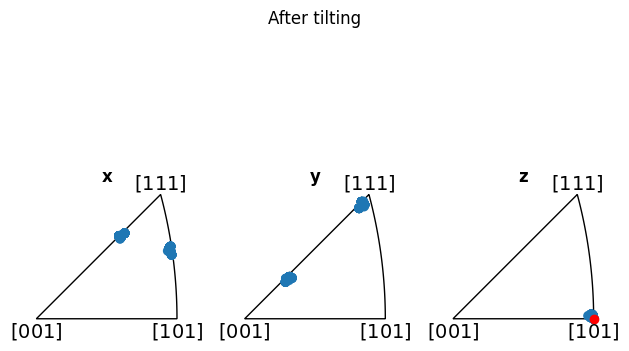

In [12]:
fig_before = circle_crop.plot_orientations()
mean_zone = circle_crop.mean_zone_axis()
fig_before.axes[-1].scatter(mean_zone, color="red")
fig_before.suptitle("Before tilting")

circle_crop.rotate_to(*circle_angles, degrees=True)
fig_after = circle_crop.plot_orientations()
mean_zone = circle_crop.mean_zone_axis()
fig_after.axes[-1].scatter(mean_zone, color="red")
fig_after.suptitle("After tilting")

## Plot the optimization landscape

Sometimes, the alignment algorithm will encounter degenerate minima in the optimization landscape.
This can be caused by symmetrically equivalent zones being available within the tilt range of the axes.
However, tiltlib does not check if this is the case.
We can check ourselves by plotting the optimization landscape.

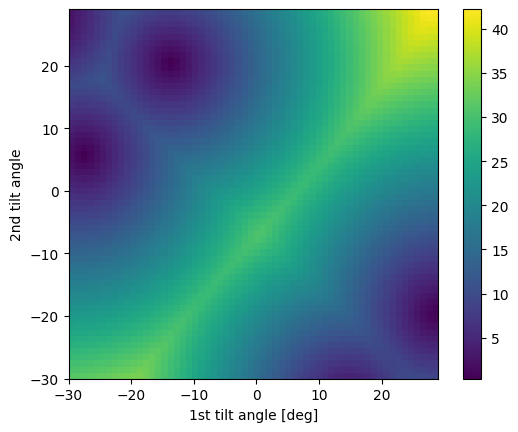

In [13]:
# Degenerate minima
target = Miller(uvw=[2, 2, 3], phase=sample.phase)
fig = box_crop.plot_angle_with(target)

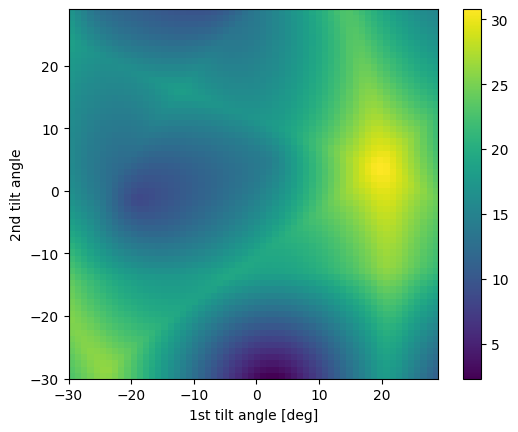

In [14]:
# Single minimum
target = Miller(uvw=[1, 0, 2], phase=sample.phase)
fig = circle_crop.plot_angle_with(target)

We can also show how using the mean orientation would look like for the twins, which should yield a completely different optimization landscape:

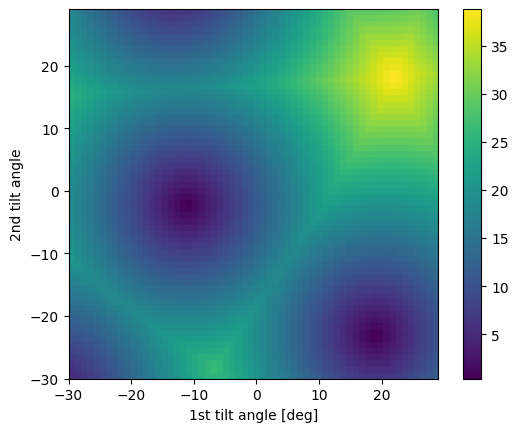

In [15]:
fig = circle_crop.plot_angle_with(target, use_mean_orientation=True)